In [1]:
!pip install keras-tuner --quiet

In [2]:
# 🧩 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

# ✅ Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 📁 Output directories
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# 🧪 2. Load & preprocess data
def load_data(path='data/train.csv'):
    df = pd.read_csv(path)
    y = df['label'].values
    X = df.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 255.0
    return train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)

# 🧠 3. Build baseline CNN model
def build_baseline_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_filters', 32, 64, step=16), (3,3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(hp.Int('conv2_filters', 32, 128, step=32), (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 🚀 4. Train model with EarlyStopping + Checkpoint
def train_model(model, X_train, y_train, X_val, y_val):
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint('models/baseline_cnn.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=2
    )
    return history

# 📊 5. Evaluate model
def evaluate_model(model, X_val, y_val):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    print("✅ Classification Report:\n", classification_report(y_val, y_pred))
    return y_pred

# 📸 6. Plot misclassified images
def plot_misclassified(X_val, y_val, y_pred, max_display=15):
    mis_idx = np.where(y_val != y_pred)[0]
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(mis_idx[:max_display]):
        plt.subplot(3, 5, i + 1)
        plt.imshow(X_val[idx].squeeze(), cmap='gray')
        plt.title(f"True: {y_val[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 🎯 Main run
X_train, X_val, y_train, y_val = load_data('/kaggle/input/digit-recognizer/train.csv')


2025-07-05 15:55:23.439111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751730923.654476      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751730923.717184      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751730942.699706      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751730942.700281      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1751730946.379564     104 service.cc:148] XLA service 0x7867dc005fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751730946.380000     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751730946.380021     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751730946.631622     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751730949.161653     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.97548, saving model to models/baseline_cnn.h5
591/591 - 9s - 15ms/step - accuracy: 0.9277 - loss: 0.2367 - val_accuracy: 0.9755 - val_loss: 0.0744
Epoch 2/20

Epoch 2: val_accuracy improved from 0.97548 to 0.98119, saving model to models/baseline_cnn.h5
591/591 - 2s - 3ms/step - accuracy: 0.9763 - loss: 0.0759 - val_accuracy: 0.9812 - val_loss: 0.0628
Epoch 3/20

Epoch 3: val_accuracy improved from 0.98119 to 0.98500, saving model to models/baseline_cnn.h5
591/591 - 2s - 3ms/step - accuracy: 0.9837 - loss: 0.0527 - val_accuracy: 0.9850 - val_loss: 0.0518
Epoch 4/20

Epoch 4: val_accuracy improved from 0.98500 to 0.98571, saving model to models/baseline_cnn.h5
591/591 - 2s - 3ms/step - accuracy: 0.9864 - loss: 0.0419 - val_accuracy: 0.9857 - val_loss: 0.0481
Epoch 5/20

Epoch 5: val_accuracy improved from 0.98571 to 0.98714, saving model to models/baseline_cnn.h5
591/591 - 2s - 3ms/step - accuracy: 0.9893 - loss: 0.0340 - val_accuracy: 0.98

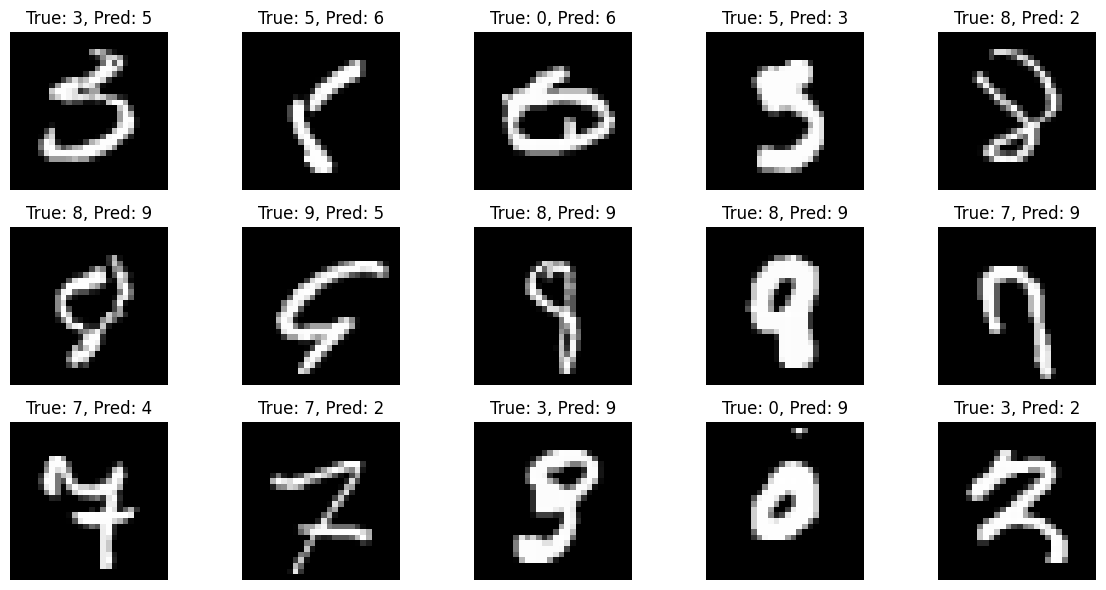

In [3]:
model = build_baseline_cnn()
history = train_model(model, X_train, y_train, X_val, y_val)
y_pred = evaluate_model(model, X_val, y_val)
plot_misclassified(X_val, y_val, y_pred)

In [4]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='outputs/tuner',
    project_name='baseline_cnn_tune'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint('models/baseline_cnn.h5', monitor='val_accuracy', save_best_only=True, verbose=1)])

Trial 10 Complete [00h 00m 42s]
val_accuracy: 0.9900000095367432

Best val_accuracy So Far: 0.9909523725509644
Total elapsed time: 00h 06m 24s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         153,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 210,346 (821.66 KB)

 Trainable params: 210,346 (821.66 KB)

 Non-trainable params: 0 (0.00 B)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       413
           1       1.00      1.00      1.00       468
           2       1.00      0.99      0.99       418
           3       1.00      0.99      0.99       435
           4       1.00      0.99      1.00       407
           5       0.99      0.98      0.98       380
           6       0.99      1.00      0.99       414
           7       1.00      0.99      0.99       440
           8       0.98      0.98      0.98       406
           9       0.98      0.99      0.98       419

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



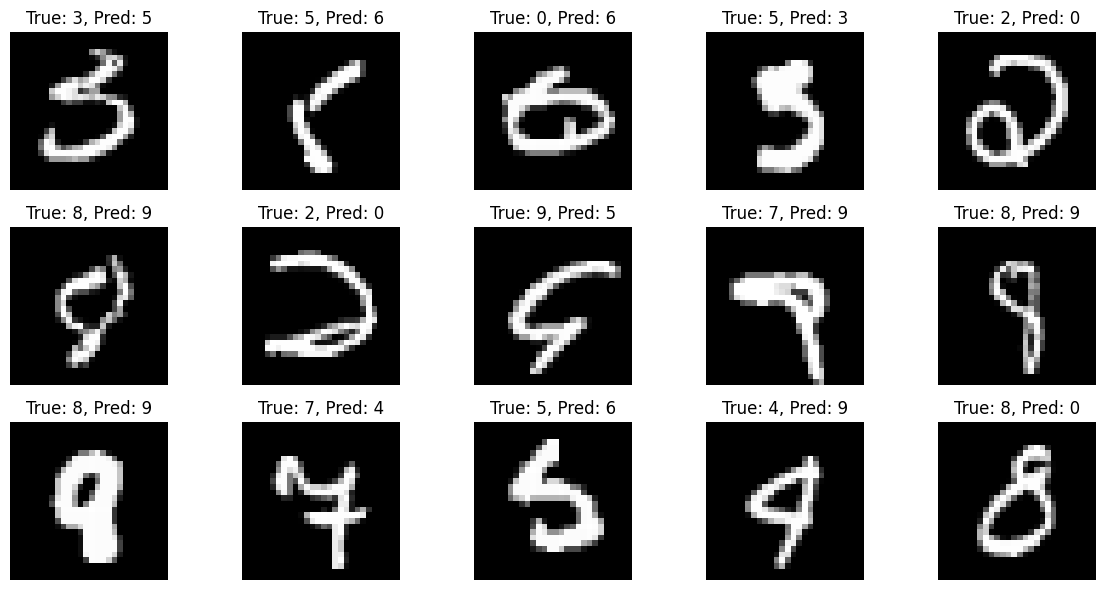

In [6]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate
y_pred = np.argmax(best_model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred))
plot_misclassified(X_val, y_val, y_pred)

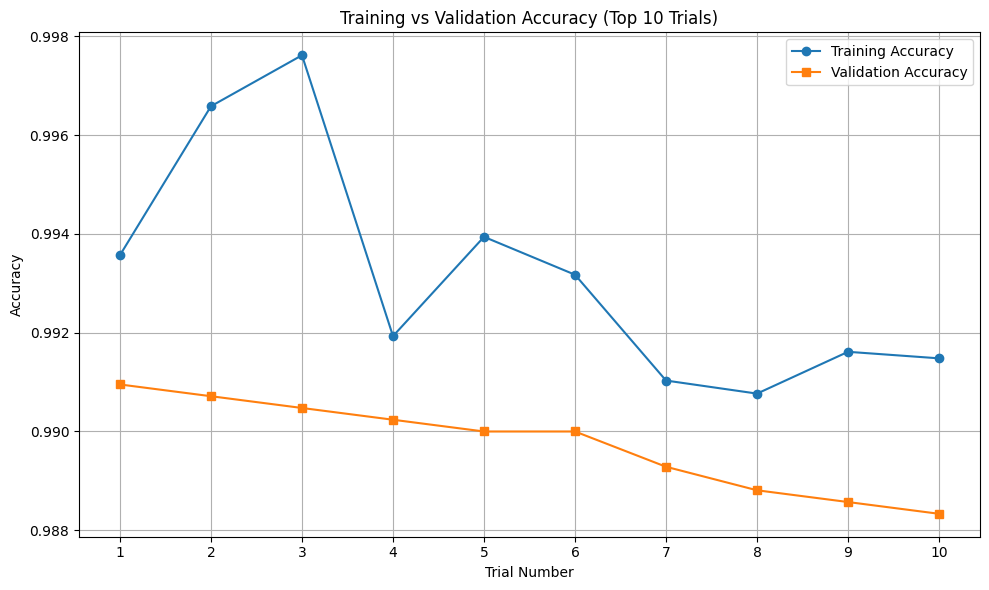

In [11]:
import matplotlib.pyplot as plt

# Collect metrics from all trials
trial_ids = []
train_accuracies = []
val_accuracies = []

for i, trial in enumerate(tuner.oracle.get_best_trials(num_trials=10)):
    trial_ids.append(i + 1)

    # Get training and validation accuracy histories
    train_hist = trial.metrics.get_history('accuracy')
    val_hist = trial.metrics.get_history('val_accuracy')

    # Safely get last accuracy values
    train_acc = train_hist[-1].value if train_hist else 0
    val_acc = val_hist[-1].value if val_hist else 0

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(trial_ids, train_accuracies, label="Training Accuracy", marker='o')
plt.plot(trial_ids, val_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Trial Number")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (Top 10 Trials)")
plt.xticks(trial_ids)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

df = pd.DataFrame({
    "Trial": trial_ids,
    "Train_Accuracy": train_accuracies,
    "Val_Accuracy": val_accuracies
})
df.to_csv("outputs/tuner_accuracy_summary.csv", index=False)

In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import os

# 📁 Step 1: Save best model
model_path = 'models/conv_base_best.h5'
best_model.save(model_path)
print(f"✅ Saved best CNN model to: {model_path}")

# 📦 Step 2: Load & preprocess test data
def load_and_preprocess_test(path='data/test.csv'):
    test_df = pd.read_csv(path)
    X_test = test_df.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    return X_test

X_test = load_and_preprocess_test('/kaggle/input/digit-recognizer/test.csv')

# 🔮 Step 3: Predict
y_test_pred = np.argmax(best_model.predict(X_test), axis=1)

# 💾 Step 4: Save predictions to CSV
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(y_test_pred) + 1),
    'Label': y_test_pred
})

filename = 'outputs/conv_base_predictions.csv'
submission.to_csv(filename, index=False)
print(f"📄 Predictions saved to {filename}")


✅ Saved best CNN model to: models/conv_base_best.h5
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
📄 Predictions saved to outputs/conv_base_predictions.csv


In [13]:
!zip -r outputs_cnn_base.zip /kaggle/working/outputs

updating: kaggle/working/outputs/ (stored 0%)
updating: kaggle/working/outputs/conv_base_predictions.csv (deflated 64%)
updating: kaggle/working/outputs/tuner/ (stored 0%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/ (stored 0%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/trial_08/ (stored 0%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/trial_08/checkpoint.weights.h5 (deflated 13%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/trial_08/build_config.json (deflated 9%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/trial_08/trial.json (deflated 66%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/trial_02/ (stored 0%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/trial_02/checkpoint.weights.h5 (deflated 9%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/trial_02/build_config.json (deflated 9%)
updating: kaggle/working/outputs/tuner/baseline_cnn_tune/trial_02/trial.json (deflated 67%)
updating: kaggl